# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train_sam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 13            
model_seed = 3           

# --- Training configuration ---
epochs = 500            

# --- Dataset configuration ---
base_data_size = 20      
dataset_type = "data"   
dataset_quantities = [0, 30, 80, 180, 380, 780]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train_sam(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


[SAM] Epoch 1/500: Train Loss 0.6958 | Test Loss 0.6954 | accs Train 0.5000 Test 0.5000


[SAM] Epoch 100/500: Train Loss 0.2642 | Test Loss 1.2685 | accs Train 0.8500 Test 0.6055


[SAM] Epoch 200/500: Train Loss 0.0879 | Test Loss 2.6755 | accs Train 1.0000 Test 0.6110


[SAM] Epoch 300/500: Train Loss 0.0284 | Test Loss 3.6598 | accs Train 1.0000 Test 0.6138


[SAM] Epoch 400/500: Train Loss 0.0081 | Test Loss 4.4151 | accs Train 1.0000 Test 0.6075


[SAM] Epoch 500/500: Train Loss 0.0020 | Test Loss 5.2327 | accs Train 1.0000 Test 0.6050
Completed training with 0 additional samples of data
[SAM] Epoch 1/500: Train Loss 0.6996 | Test Loss 0.6949 | accs Train 0.5000 Test 0.5000


[SAM] Epoch 100/500: Train Loss 0.4121 | Test Loss 0.7145 | accs Train 0.8000 Test 0.6492


[SAM] Epoch 200/500: Train Loss 0.2981 | Test Loss 0.9611 | accs Train 0.8800 Test 0.6462


[SAM] Epoch 300/500: Train Loss 0.1608 | Test Loss 1.4155 | accs Train 0.9400 Test 0.6452


[SAM] Epoch 400/500: Train Loss 0.1147 | Test Loss 1.5837 | accs Train 0.9400 Test 0.6435


[SAM] Epoch 500/500: Train Loss 0.0824 | Test Loss 1.8663 | accs Train 0.9600 Test 0.6428
Completed training with 30 additional samples of data
[SAM] Epoch 1/500: Train Loss 0.7061 | Test Loss 0.6948 | accs Train 0.4500 Test 0.5000


[SAM] Epoch 100/500: Train Loss 0.4393 | Test Loss 0.6875 | accs Train 0.8000 Test 0.6538


[SAM] Epoch 200/500: Train Loss 0.3773 | Test Loss 0.6939 | accs Train 0.8100 Test 0.6630


[SAM] Epoch 300/500: Train Loss 0.2959 | Test Loss 0.6795 | accs Train 0.9200 Test 0.7525


[SAM] Epoch 400/500: Train Loss 0.1809 | Test Loss 0.6621 | accs Train 0.9400 Test 0.7588


[SAM] Epoch 500/500: Train Loss 0.1011 | Test Loss 0.7694 | accs Train 0.9600 Test 0.7855
Completed training with 80 additional samples of data
[SAM] Epoch 1/500: Train Loss 0.7063 | Test Loss 0.6948 | accs Train 0.4450 Test 0.5000


[SAM] Epoch 100/500: Train Loss 0.5127 | Test Loss 0.6238 | accs Train 0.7400 Test 0.6520


[SAM] Epoch 200/500: Train Loss 0.4381 | Test Loss 0.5650 | accs Train 0.7200 Test 0.6290


[SAM] Epoch 300/500: Train Loss 0.3323 | Test Loss 0.4628 | accs Train 0.8250 Test 0.7302


[SAM] Epoch 400/500: Train Loss 0.1660 | Test Loss 0.2618 | accs Train 0.9750 Test 0.8992


[SAM] Epoch 500/500: Train Loss 0.0544 | Test Loss 0.1228 | accs Train 0.9950 Test 0.9555
Completed training with 180 additional samples of data
[SAM] Epoch 1/500: Train Loss 0.7060 | Test Loss 0.6949 | accs Train 0.4475 Test 0.5000


[SAM] Epoch 100/500: Train Loss 0.5233 | Test Loss 0.6272 | accs Train 0.7325 Test 0.6560


[SAM] Epoch 200/500: Train Loss 0.4722 | Test Loss 0.5739 | accs Train 0.7600 Test 0.6783


[SAM] Epoch 300/500: Train Loss 0.1985 | Test Loss 0.2444 | accs Train 0.9500 Test 0.9130


[SAM] Epoch 400/500: Train Loss 0.0342 | Test Loss 0.0487 | accs Train 1.0000 Test 0.9915


[SAM] Epoch 500/500: Train Loss 0.0101 | Test Loss 0.0174 | accs Train 1.0000 Test 0.9980
Completed training with 380 additional samples of data
[SAM] Epoch 1/500: Train Loss 0.7020 | Test Loss 0.6948 | accs Train 0.4750 Test 0.5000


[SAM] Epoch 100/500: Train Loss 0.5631 | Test Loss 0.6050 | accs Train 0.6987 Test 0.6625


[SAM] Epoch 200/500: Train Loss 0.4487 | Test Loss 0.4808 | accs Train 0.7525 Test 0.7145


[SAM] Epoch 300/500: Train Loss 0.1262 | Test Loss 0.1379 | accs Train 0.9888 Test 0.9795


[SAM] Epoch 400/500: Train Loss 0.0251 | Test Loss 0.0323 | accs Train 0.9938 Test 0.9905


[SAM] Epoch 500/500: Train Loss 0.0095 | Test Loss 0.0133 | accs Train 1.0000 Test 0.9985
Completed training with 780 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 5.2327 | accs: 0.6050
  30 samples | Test Loss: 1.8663 | accs: 0.6428
  80 samples | Test Loss: 0.7694 | accs: 0.7855
 180 samples | Test Loss: 0.1228 | accs: 0.9555
 380 samples | Test Loss: 0.0174 | accs: 0.9980
 780 samples | Test Loss: 0.0133 | accs: 0.9985

=== Model Diagnostics by Training Data ===

Dataset type: data, additional samples: 0
 Model    0 | Train Loss: 0.0020 | accs: 1.0000
 Model   30 | Train Loss: 0.1373 | accs: 0.9000
 Model   80 | Train Loss: 0.1571 | accs: 0.9500
 Model  180 | Train Loss: 0.0691 | accs: 0.9500
 Model  380 | Train Loss: 0.0121 | accs: 1.0000
 Model  780 | Train Loss: 0.0080 | accs: 1.0000

Dataset type: data, additional samples: 30
 Model    0 | Train Loss: 3.3944 | accs: 0.7000
 Model   30 | Train Loss: 0.0820 | accs: 0.9600
 Model   80 | Train Loss: 0.1280 | accs: 0.9400
 Model  180 | Train Loss: 0.0627 | accs: 0.9800
 Model  380 | Train Loss: 0.0091 | accs: 1.0000
 Model  780 | Train Loss:

### Model + Data Specific Verification

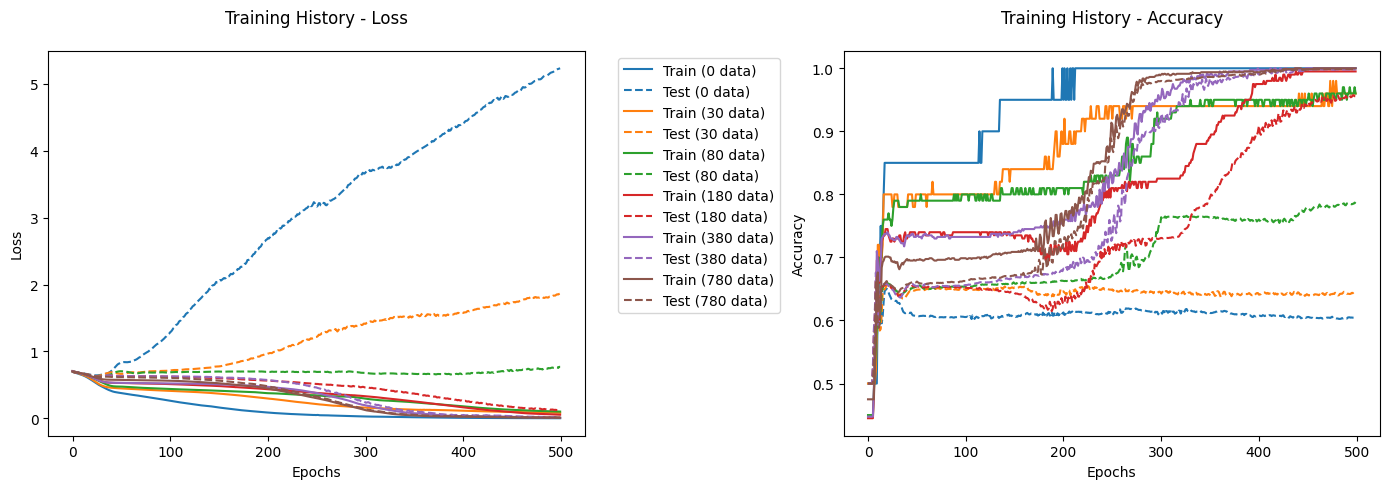

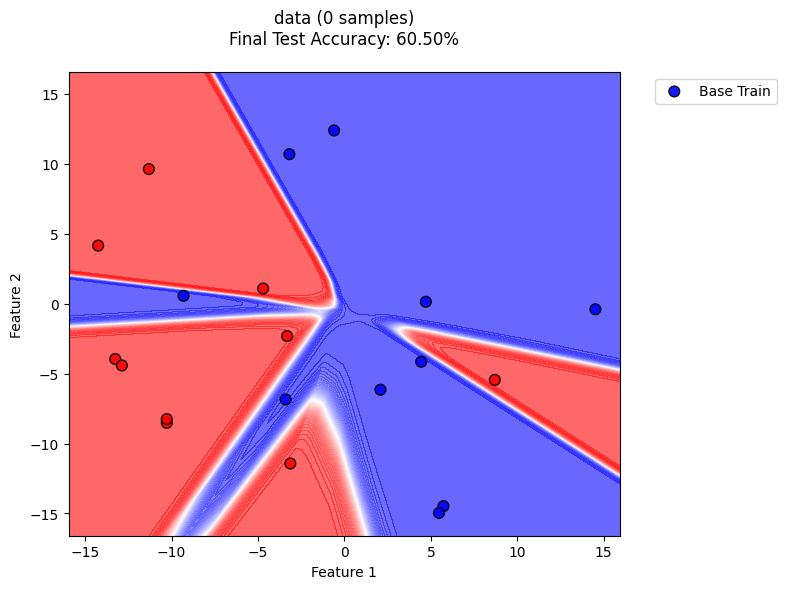

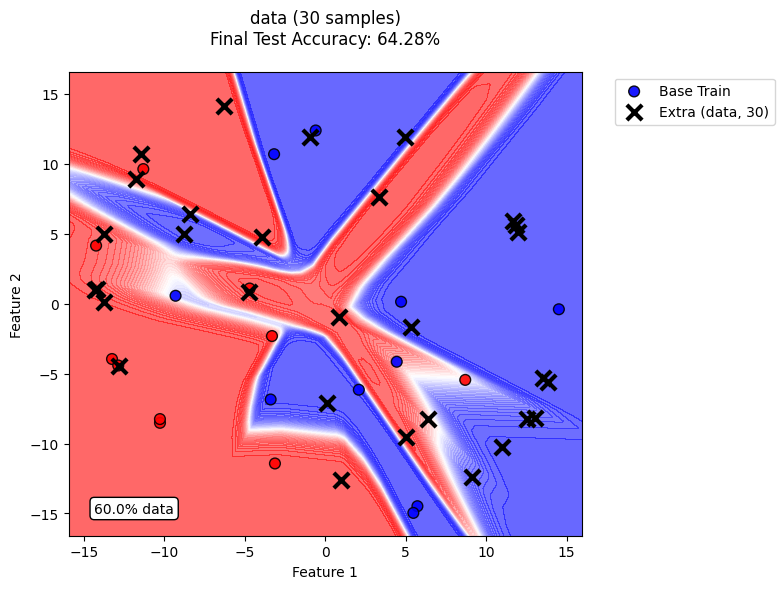

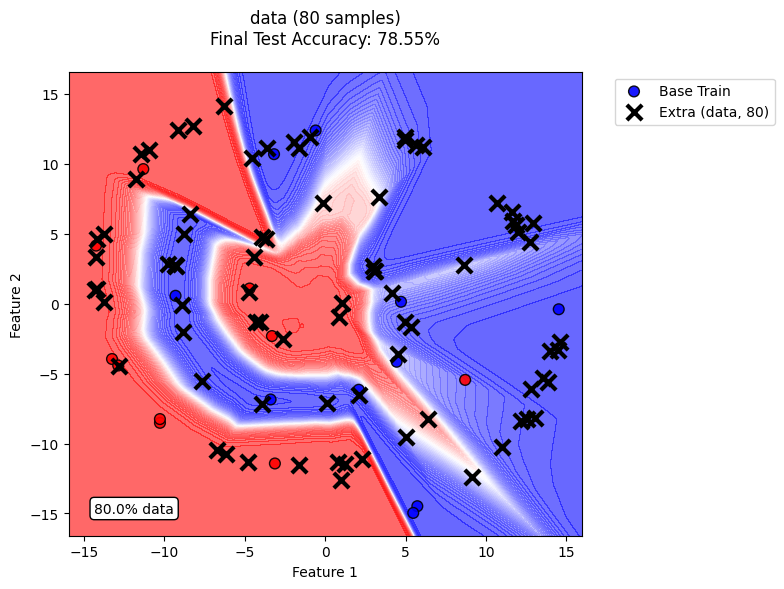

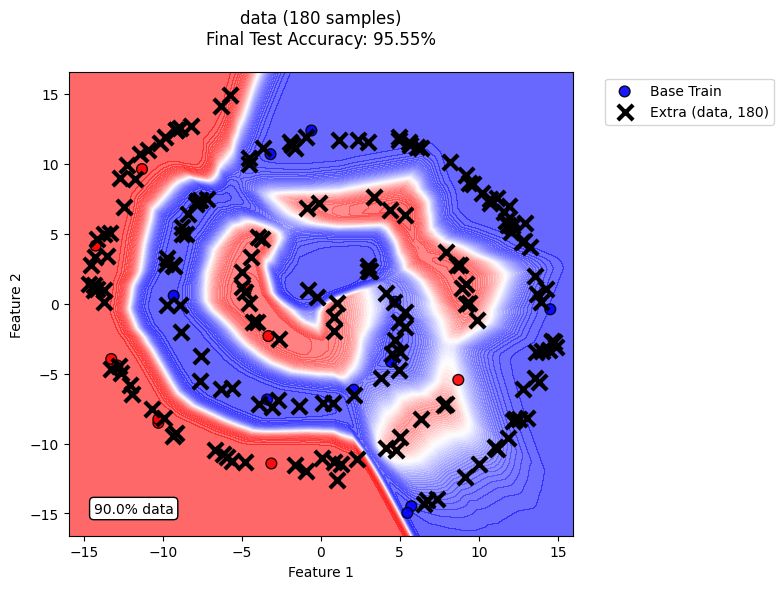

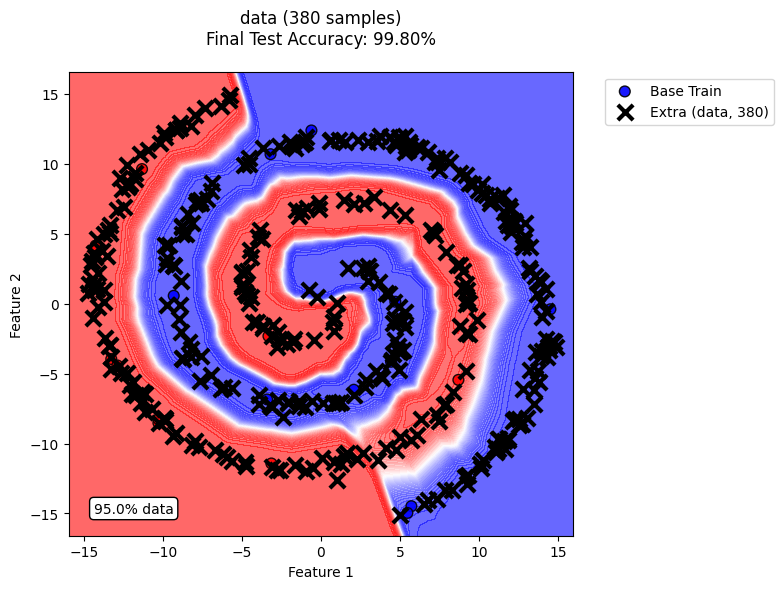

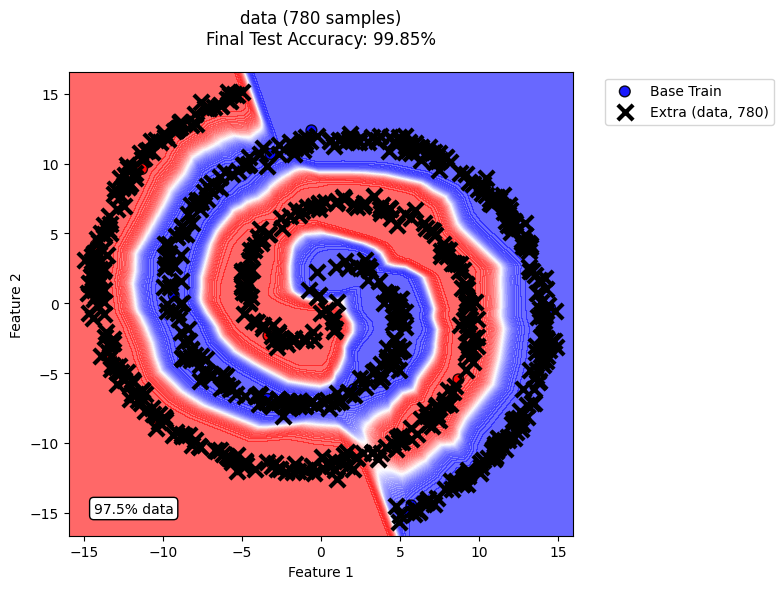

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_30.pt
Saved model: models_and_data/model_additional_30.pt
✅ Model saved to models_and_data\model_additional_80.pt
Saved model: models_and_data/model_additional_80.pt
✅ Model saved to models_and_data\model_additional_180.pt
Saved model: models_and_data/model_additional_180.pt
✅ Model saved to models_and_data\model_additional_380.pt
Saved model: models_and_data/model_additional_380.pt
✅ Model saved to models_and_data\model_additional_780.pt
Saved model: models_and_data/model_additional_780.pt
